In [1]:
# %load post_procesamiento.py
import os
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import integrate

# Datos experimentales a los cuales comprar
moleculas_quencher = 0, 9, 46, 82, 119, 156, 229, 351, 656, 1267, 2487,\
                     4929, 9289, 20190
cociente_tau = 1.000, 1.004, 1.489, 1.947, 2.429, 2.625, 3.320, 3.978, \
               5.363, 6.484, 7.371, 7.024, 7.820, 8.913
cociente_i = np.array([1.000, 1.061, 1.677, 2.117, 2.645, 3.031, 3.879,\
                       5.124, 6.840, 9.511, 11.775, 13.822, 16.141, 19.930])

eff_teo = 1 - cociente_i**(-1)

def bi_exp(x, a_1, b_1, a_2, b_2):
    return a_1**2  * np.exp(x / -b_1) + a_2**2 * np.exp(x / -b_2)
    
def bi_exp_norm(x, a_1, b_1, a_2, b_2):
    c = a_1 * b_1 + a_2 * b_2
    return (a_1 * np.exp(x / -b_1) + a_2 * np.exp(x / -b_2)) / c

def read_param_hist(path):
#Leemos los parametors del ajuste de ramiro, calculamos su area y se la
#agregamos como un parametro mas
    with open(path, 'r') as hist:
        line = hist.readline()
        param_hist_ramiro = []
        while line != '':
            line =' '.join(line.split())
            param = np.array(line.split(), dtype=np.float)
            area = integrate.quad(bi_exp, 0, np.inf,
                                  args=(param[1], param[2], param[3],
                                        param[4]))[0]
            param = param.tolist()
            param_hist_ramiro.append(np.array(param + [area]))
            line = hist.readline()
        return param_hist_ramiro
    
# Leemos los datos del hist.dat
'''
Lee el hist.dat, devuelve una lista con #aceptores y una lista de
arrays con los datos del histograma
'''        
def read_hist(path_hist):        
    with open(path_hist, 'r') as hist:
        line = hist.readline()
        num_aceptores = []
        decaimientos = []
        while line != '':
            values = list(eval(line))
            num_aceptores.append(values.pop(0))
            decaimientos.append(np.array(values))
            line = hist.readline()
        return(num_aceptores, decaimientos)

# Leemos el result.dat
def read_result(path_result):
    datos_quenching = open(path_result, 'r')
    line = datos_quenching.readline()
    while 'Traps number' not in line:
        line = datos_quenching.readline()
    junk, traps_number = line.split(': ')
    traps_number = eval(traps_number)
    while 'Acceptors number' not in line:
        line = datos_quenching.readline()
    junk, aceptors_number = line.split(': ')
    aceptors_number = eval(aceptors_number)
    while  not 'aceptores' in line and not 'Tiempo' in line:
        line = datos_quenching.readline()
        if 'Delta_t' in line:
            delta_t = (float(line.split(', ')[0].split(': ')[1]))
        if line == '':
            break
    lista_valores = []
    while True:
        line = datos_quenching.readline()
        if line == '\n':                    
            continue
        if '-'*10 in line:
            break
        # Removemos el enter al final de linea
        valores = '\t'.join(line.split('\n'))

        # Removemos todos los '\t'    
        valores = (' '.join(valores.split('\t')))
        # Removemos los espacios que nos quedan
        valores = np.array([float(valor) for valor in valores.split(' ') \
                            if valor != ''])
        lista_valores.append(valores)
        
    datos_quenching.close()
    return (lista_valores, delta_t)

def area_hist(decaimiento, delta_t):
    n, bins = np.histogram(decaimiento*delta_t, bins=max(decaimiento))
    popt, pcov = curve_fit(bi_exp, bins[:-1], n)
    area = popt[0]**2 * popt[1] + popt[2]**2 * popt[3]
    return area, popt

def pasar_a_bins(param_ramiro, hist, delta_t):
    out = []
    for histograma in histogramas:
        n, bins = np.histogram(histograma*delta_t, bins=max(histograma), normed=True)
        alturas_bins_ramiro = []
        for i in range(len(bins)):
            area_bin = integrate.quad(bi_exp_norm, delta_t*i, delta_t*(i+1), args=(param_ramiro[1], param_ramiro[2],
                                                                              param_ramiro[3], param_ramiro[4]))[0]
            altura_bin = area_bin / delta_t
            alturas_bins_ramiro.append(altura_bin)
        out.append([bins, n, alturas_bins_ramiro])
    return out

def extrac_param(string):
    params = string.split('_')
    mean_free_path = params[1]
    num_tramp = params[2]
    radio_tramp = params[3][:-4]
    return mean_free_path, num_tramp, radio_tramp

In [2]:
param_ramiro = read_param_hist('hist_ramiro.dat')
num_acept, histogramas = read_hist('hist.dat')
result, delta_t = read_result('result.dat')  

In [4]:
out = pasar_a_bins(param_ramiro[0], histogramas, delta_t)

diffs = []
for salida in out:
    diff = 0
    for i in range(len(salida[1])):
        diff += np.abs(salida[1][i] - salida[2][i])
    diffs.append(diff)

In [5]:
df = pd.DataFrame(columns=["mean free path", 'tramps', 'r_tramps', 'error_areas'])

In [6]:
os.chdir('../../out/')

In [21]:
df = pd.DataFrame(columns=['mean free path', 'num tramp', 'radio tramps', 'eeff', 'earea'])

In [22]:
df.loc[0] = 100, 5, 3, 100, 120

In [7]:
list_dirs = os.listdir('.')
list_dirs.sort()
list_hist = list_dirs[:int(len(list_dirs)/2)]
list_result = list_dirs[int(len(list_dirs)/2):]

# Ojo con donde esta esto!
#param_ramiro = read_param_hist('hist_ramiro.dat')

df = pd.DataFrame(columns=['mean free path', 'num tramp', 'radio tramps', 'eeff', 'earea'])

for hist, result in zip(list_hist, list_result):
    num_acept, histogramas = read_hist(hist)
    result, delta_t = read_result(result)  

hist_100.00_10_1.00.dat result_100.00_10_1.00.dat
hist_100.00_10_2.00.dat result_100.00_10_2.00.dat
hist_100.00_10_3.00.dat result_100.00_10_3.00.dat
hist_100.00_10_4.00.dat result_100.00_10_4.00.dat
hist_100.00_10_5.00.dat result_100.00_10_5.00.dat
hist_100.00_15_1.00.dat result_100.00_15_1.00.dat
hist_100.00_15_2.00.dat result_100.00_15_2.00.dat
hist_100.00_15_3.00.dat result_100.00_15_3.00.dat
hist_100.00_15_4.00.dat result_100.00_15_4.00.dat
hist_100.00_15_5.00.dat result_100.00_15_5.00.dat
hist_100.00_1_1.00.dat result_100.00_1_1.00.dat
hist_100.00_1_2.00.dat result_100.00_1_2.00.dat
hist_100.00_1_3.00.dat result_100.00_1_3.00.dat
hist_100.00_1_4.00.dat result_100.00_1_4.00.dat
hist_100.00_1_5.00.dat result_100.00_1_5.00.dat
hist_100.00_20_1.00.dat result_100.00_20_1.00.dat
hist_100.00_20_2.00.dat result_100.00_20_2.00.dat
hist_100.00_20_3.00.dat result_100.00_20_3.00.dat
hist_100.00_20_4.00.dat result_100.00_20_4.00.dat
hist_100.00_20_5.00.dat result_100.00_20_5.00.dat
hist_100.0

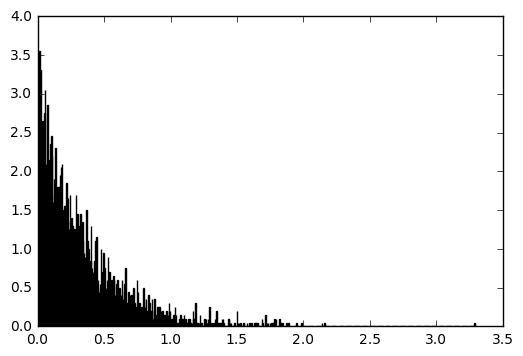

In [8]:
plt.bar(out[0][0][:-1], out[0][1], width=delta_t)

plt.show()

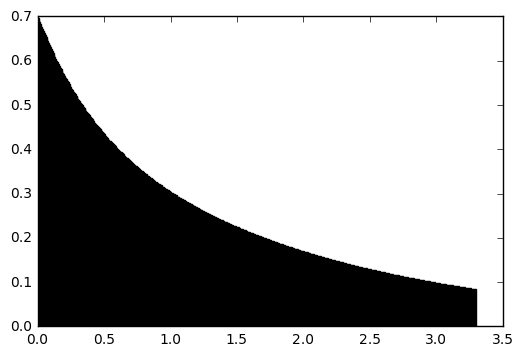

In [63]:
plt.bar(out[0][0], out[0][2], width=delta_t)
plt.show()

In [64]:
sum(out[0][2]) * delta_t

0.8425253341995188

In [33]:
# Ver si se toma norma o el cuadrado
for salida in out:
    diff = 0
    for i in range(len(salida[1])):
        diff += (salida[1][i] - salida[2][i])**2
    print(diff)

118.547671423
379.538214616
2389.25658335
4396.91668514
6290.25444861
7537.40229739
9053.98430396
11030.3952816


In [70]:
print(diff)

136.608541435


In [35]:
len(out)

8